### Projet 4: decomposer une image sur une base d'ondlelettes.
========
========
--------
Combal Quentin

Cocogne Romain

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import scipy
%matplotlib inline 


 1) Programmer l'algorithme obtenu à la fin de la séance pour un vecteur de taille ${2^{q}}$ où q
est un entier strictement positif arbitraire.

In [20]:
def indicesdemi(depth):
    w=np.zeros((depth,depth))
    for i in range(depth//2):
        w[i,2*i:2*i+2]=0.5
        w[depth//2+i,2*i]=-0.5
        w[depth//2+i,2*i+1]=0.5
    return w

def wn(n,depth):
    w=indicesdemi(depth)
    w_n=np.identity(n)
    w_n[:depth,:depth]=w
    return w_n
def kn(n,depth):
    k=indicesdemi(depth)
    k=2*k.T
    k_n=np.identity(n)
    k_n[:depth,:depth]=k
    return k_n

def decompose1D (vect,q):
    p=vect.size
    w=[]
    while(vect.size>p-2**q+1 and vect.size>1):
        w.append(np.array((vect[1::2]-vect[:-1:2])/2))
        vect=(vect[1::2]+vect[:-1:2])/2
    return vect,w

def decompose1Dmat(vect,q):
    p=vect.size
    i=0
    while(2**i<p and i<q):
        vect=vect@wn(vect.size,vect.size//2**i).T
        i+=1
    return vect

In [39]:
v0=np.array([7,1,6,6,3,-5,4,2])
print(decompose1D(v0,3))
v0=np.array([7,1,6,6,3,-5,4,2])
v0_comp=decompose1Dmat(v0,2)
print(v0_comp)

(array([3.]), [array([-3.,  0., -4., -1.]), array([1., 2.]), array([-2.])])
[ 5.  1.  1.  2. -3.  0. -4. -1.]


In [53]:
def recompose1Dmat(vect,q):
    i=q
    while(i>0):
        k=(kn(vect.size,vect.size//2**(i-1)))
        vect=vect@k.T
        i-=1
    return vect

In [54]:
new_v0=recompose1Dmat(v0_comp,2)
print(new_v0)

[ 7.  1.  6.  6.  3. -5.  4.  2.]


2) Étendre l'algorithme précédent au cas d'une image (Lena.png). Il faudra veiller au formalisme
mathématique lorsque la décomposition sera écrite sous forme matricielle. Programmer
l'algorithme proposé puis étudier et expliquer ses performances sur le image fournies par l'ingénieur.

In [42]:
def plot (img,title="",limite=1):
    if(np.size(img.shape)==2):
        plt.figure(1,figsize=(10,10))
        plt.subplot(111), plt.imshow(np.abs(img), cmap = 'gray',vmax=np.max(img)*limite,vmin=0)
        plt.title(title + str(img.shape)) 
        plt.show()
    else:
        plt.figure(1,figsize=(10,10))
        plt.subplot(111), plt.plot(img)
        plt.show()


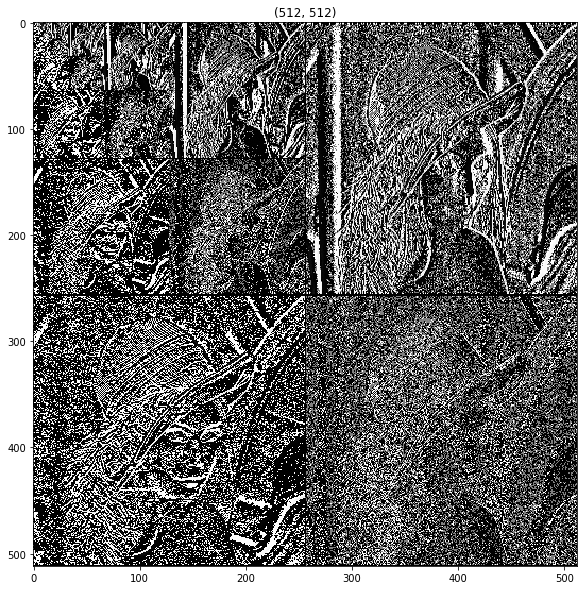

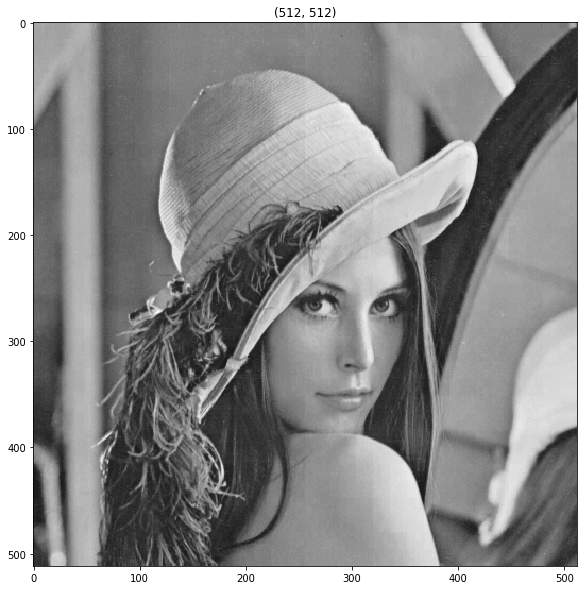

In [94]:
def decompose2Dmat (img,q):
    vect=img
    for d in range(q):
        temp=vect[:vect.shape[0]//(2**d),:vect.shape[1]//(2**d)]
        for i in range(temp.shape[0]):
            temp[i,:]=decompose1Dmat(temp[i,:],1)
        for i in range(temp.shape[1]):
            temp[:,i]=decompose1Dmat(temp[:,i],1)
        vect[:vect.shape[0]//(2**d),:vect.shape[1]//(2**d)]=temp
    return vect

def recompose2Dmat (img,q):
    vect=img
    for d in np.arange(q-1,-1,-1):
        temp=vect[:vect.shape[0]//(2**d),:vect.shape[1]//(2**d)]
        for i in range(temp.shape[1]):
            temp[:,i]=recompose1Dmat(temp[:,i],1)
        for i in range(temp.shape[0]):
            temp[i,:]=recompose1Dmat(temp[i,:],1)
        vect[:vect.shape[0]//(2**d),:vect.shape[1]//(2**d)]=temp
    return vect

img = cv2.imread("lena.png",0)
img_dec=decompose2Dmat(img,9)
plot(img_dec)
img_rec=recompose2Dmat(img_dec,9)
plot(img_rec)

In [95]:
np.log2(512)

9.0

#### Cette méthode est limitée par la taille de l'image. On ne peut faire que ln(shape) opérations (ici ln(512)=9). 

#### Cette méthode n'est pas efficace à programmer, même si l'image finale obtenue est bien réduite.

#### La restauration de l'image est efficace, mais pour de grandes valeurs de Q, on observe une légère pixelisation.

3)Applications de la transformée de Haar.
Method:

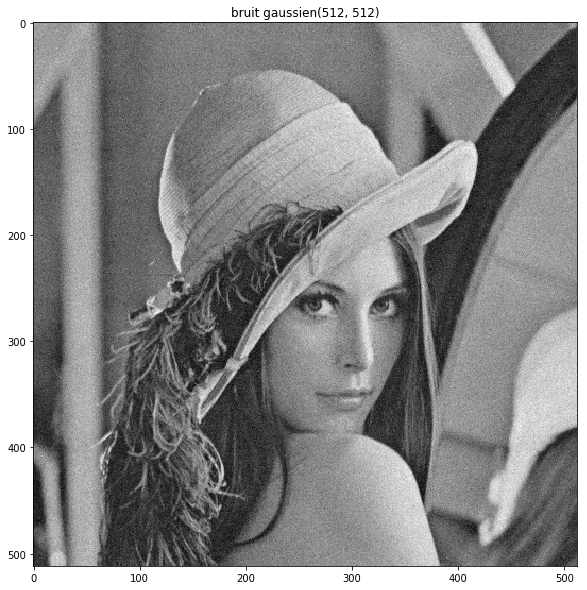

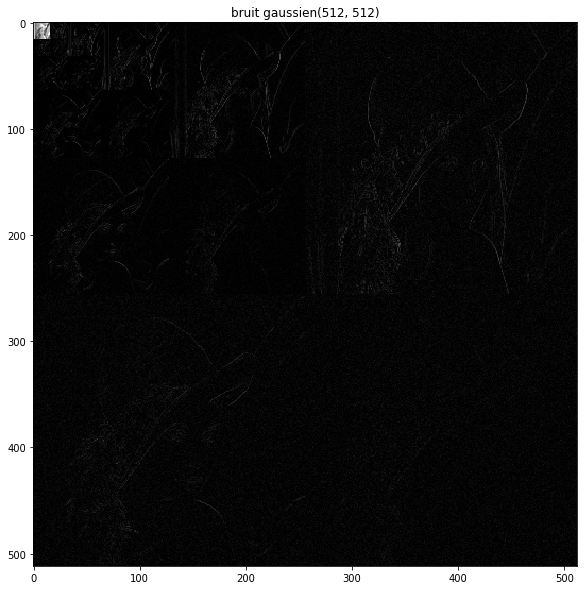

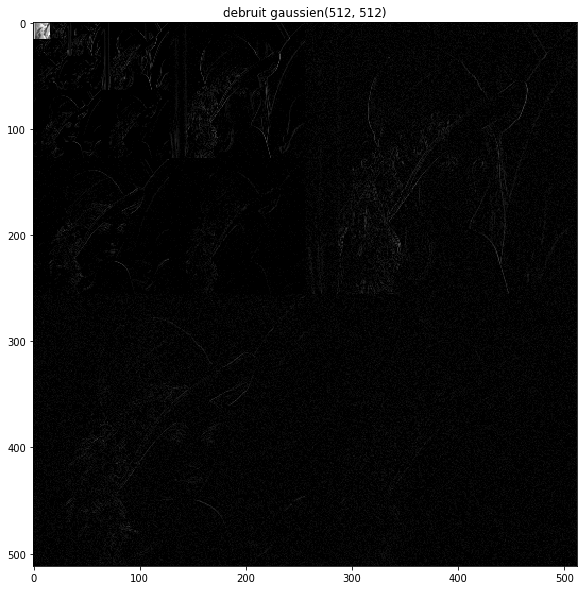

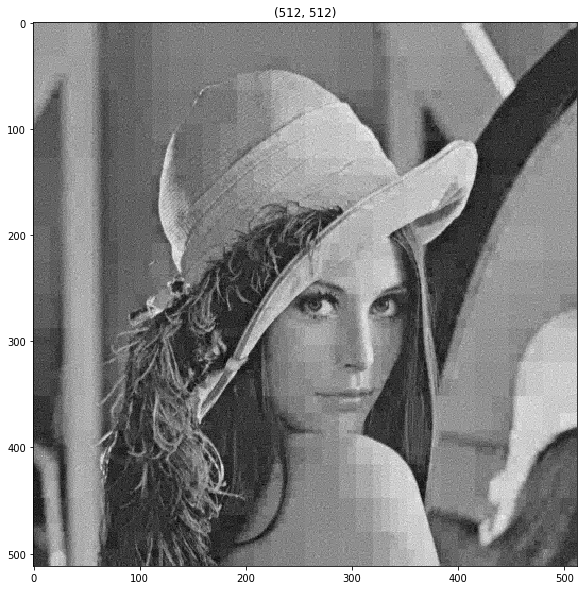

In [99]:
def bruit_gauss (img, var):
    b=np.random.normal(0,var**0.5, img.shape)
    img_bruit=img+b
    return b, img_bruit

img = cv2.imread("lena.png",0)

var=100
q=5
s=var**0.5*np.sqrt(2*np.log2(q))
bruit,img_bruit=bruit_gauss(img,var)
plot(img_bruit,"bruit gaussien")

img_dec=decompose2Dmat(img_bruit,q)
plot(img_dec,"bruit gaussien")

img_dec[abs(img_dec)<q]=0
plot(img_dec,"debruit gaussien")
img_rec=recompose2Dmat(img_dec,q)
plot(img_dec)

#### L'efficacité de cette méthode dépend de l'utilisation. En fonction des paramètres choisis, on peut avoir une image bruitée mais pas trop dégradée ou une image sans bruit mais très pixelisée.

#### Une décompostion à grand niveau de décomposition est plus efficace pour filtrer le bruit mais pixelise beaucoup l'image.

#### A l'inverse, un petit niveau de décomposition va garder du bruit mais l'image ne sera pas trop dégradée. 

#### Le seuil est arbitraire et va jouer enormément sur le résultat; Un petit seuil va garder le bruit, alors qu'un grand seuil va effacer des parties de l'image.